# Set-Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Config

In [2]:
config = {
    "fontsize": 24
}


# Plotting Linear Probe Results

## Preprocessing Results

In [45]:
folder_path = '/content/drive/MyDrive/SAEs_for_Genomics/linear_probe_results/'

# Load the summary files
original_df = pd.read_csv(folder_path + 'probe_results_NT50.L12mlp_summary_20250311_185333_val012.csv', index_col=0)
onehot_df = pd.read_csv(folder_path + 'probe_results_control.onehottokens_summary_20250311_212444_val012.csv', index_col=0)

def preprocess(df):
    # Reset index to make it easier to manipulate
    df = df.reset_index()

    # Rename the first column to ensure it's properly named
    df = df.rename(columns={df.columns[0]: 'annotation_name'})

    # Remove rows where annotation_name is NaN or explicitly 'NaN' or 'annotation'
    df = df[~df['annotation_name'].isin(['NaN', 'annotation'])]
    df = df.dropna(subset=['annotation_name'])

    # Rename columns to ensure correct naming
    col_mapping = {col: col.replace('.1', '_std') for col in df.columns}
    df = df.rename(columns=col_mapping)

    # Convert numeric columns to float
    for col in df.columns:
        if col != 'annotation_name':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop any rows that now have NaN values in critical columns
    df = df.dropna(subset=['f1', 'f1_std'])

    # Set the index back to the annotation names
    df = df.set_index('annotation_name')

    return df

# Process both dataframes
original_df = preprocess(original_df)
onehot_df = preprocess(onehot_df)

# Check for any remaining NaN values
print("Any NaNs in original_df:", original_df.isnull().any().any())
print("Any NaNs in onehot_df:", onehot_df.isnull().any().any())

original_df

Any NaNs in original_df: False
Any NaNs in onehot_df: False


,f1,f1_std,precision,precision_std,accuracy,accuracy_std,recall,recall_std
annotation_name,,,,,,,,
AmpR,0.3592,0.0061,0.2244,0.0054,0.8915,0.0045,0.9009,0.0154
AmpR promoter,0.2272,0.0236,0.1291,0.0151,0.9608,0.0062,0.9589,0.0079
CMV enhancer,0.6978,0.0129,0.5415,0.0157,0.9806,0.0012,0.9811,0.0027
EGFP,0.2944,0.0087,0.1755,0.0063,0.9309,0.0032,0.9135,0.0086
KanR,0.2980,0.0059,0.1779,0.0044,0.9172,0.0030,0.9186,0.0123
SV40 promoter,0.3151,0.0125,0.1884,0.0088,0.9670,0.0019,0.9638,0.0051
f1 ori,0.3878,0.0072,0.2439,0.0060,0.9470,0.0018,0.9467,0.0044
luciferase,0.0739,0.0047,0.0385,0.0026,0.9027,0.0089,0.8904,0.0239
mCherry,0.1743,0.0066,0.0961,0.0040,0.9464,0.0025,0.9421,0.0123


## Determine Stat Significance

Are the average F1 scores between conditions signficiantly different?

In [58]:
import scipy.stats as stats
import numpy as np
import pandas as pd

def perform_paired_ttest(df1, df2, metric='f1', n=5):
    """
    Perform paired t-test between two dataframes for a specified metric.

    Parameters:
    df1, df2: pandas DataFrames with the same structure and annotation names
    metric: the metric column to compare (default: 'f1')
    n: Number of runs per group (default: 5)

    Returns:
    DataFrame with t-test results
    """

    # first lets check that normality condition holds
    from scipy.stats import shapiro

    diff = df1[metric] - df2[metric]
    shapiro_test = shapiro(diff)
    assert shapiro_test.pvalue > 0.05, "Fail to reject normality assumption"


    # Check if annotation names match
    if df1.index.tolist() != df2.index.tolist():
        raise ValueError("The annotation names in the two dataframes do not match or are not in the same order")

    # Compute the difference
    diff = df1[metric] - df2[metric]

    # Compute standard deviation of differences
    std_diff = np.std(diff, ddof=1)

    # Compute standard error
    se_diff = std_diff / np.sqrt(n)

    # Compute t-statistic
    t_stat = diff / se_diff

    # Compute p-values using two-tailed test
    p_values = stats.t.sf(np.abs(t_stat), df=n-1) * 2


    # Create results dataframe
    results = pd.DataFrame({
        'annotation_name': df1.index.values.tolist(),
        f'{metric}_df1': df1[metric],
        f'{metric}_df2': df2[metric],
        'difference': diff,
        'std_diff': std_diff,
        'std_error': se_diff,
        't_statistic': t_stat,
        'p_value': p_values,
        'significant': p_values < 0.05
    })

    return results

# Example usage:
results = perform_paired_ttest(original_df, onehot_df, metric='f1')
print(results)


                annotation_name  f1_df1  f1_df2  difference  std_diff  \
annotation_name                                                         
AmpR                       AmpR  0.3592  0.1779      0.1813  0.077054   
AmpR promoter     AmpR promoter  0.2272  0.1706      0.0566  0.077054   
CMV enhancer       CMV enhancer  0.6978  0.3853      0.3125  0.077054   
EGFP                       EGFP  0.2944  0.1228      0.1716  0.077054   
KanR                       KanR  0.2980  0.1177      0.1803  0.077054   
SV40 promoter     SV40 promoter  0.3151  0.1375      0.1776  0.077054   
f1 ori                   f1 ori  0.3878  0.1550      0.2328  0.077054   
luciferase           luciferase  0.0739  0.0167      0.0572  0.077054   
mCherry                 mCherry  0.1743  0.0440      0.1303  0.077054   
ori                         ori  0.5272  0.3154      0.2118  0.077054   

                 std_error  t_statistic   p_value  significant  
annotation_name                                           

In [71]:
avg_diff = results['difference'].mean()
avg_diff

0.1712

## Compute class-frequencies as reference

In [21]:
# compute class frequencies

# load token_df for >= 1000 seqs
token_df_1k_s1 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/sae_latent_eval/annotated_seqs/token_df_1k_ss1.csv')
token_df_1k_s2 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/sae_latent_eval/annotated_seqs/token_df_1k_ss2.csv')
token_df_1k_s0 = pd.read_csv('/content/drive/MyDrive/SAEs_for_Genomics/sae_latent_eval/annotated_seqs/token_df_1k_ss0.csv')


In [59]:
# concat
token_df = pd.concat([token_df_1k_s1, token_df_1k_s2, token_df_1k_s0])
token_df.head()

# get class-frequencies
class_frequencies = token_df['token_annotations'].value_counts(normalize=True)
class_frequencies

# convert annotations in class_frequencies from '['ann']' to 'ann'
class_frequencies.index = [anno[2:-2] for anno in class_frequencies.index]
class_frequencies

annotations = original_df.index.tolist()

filtered_frequencies = {}
for anno in annotations:
    if anno in class_frequencies.index:
        filtered_frequencies[anno] = class_frequencies[anno]
    else:
        filtered_frequencies[anno] = 0  # Default value for missing annotations

class_frequencies_ordered = pd.Series(filtered_frequencies, index=annotations)
frequencies = class_frequencies_ordered.values

## Plotting

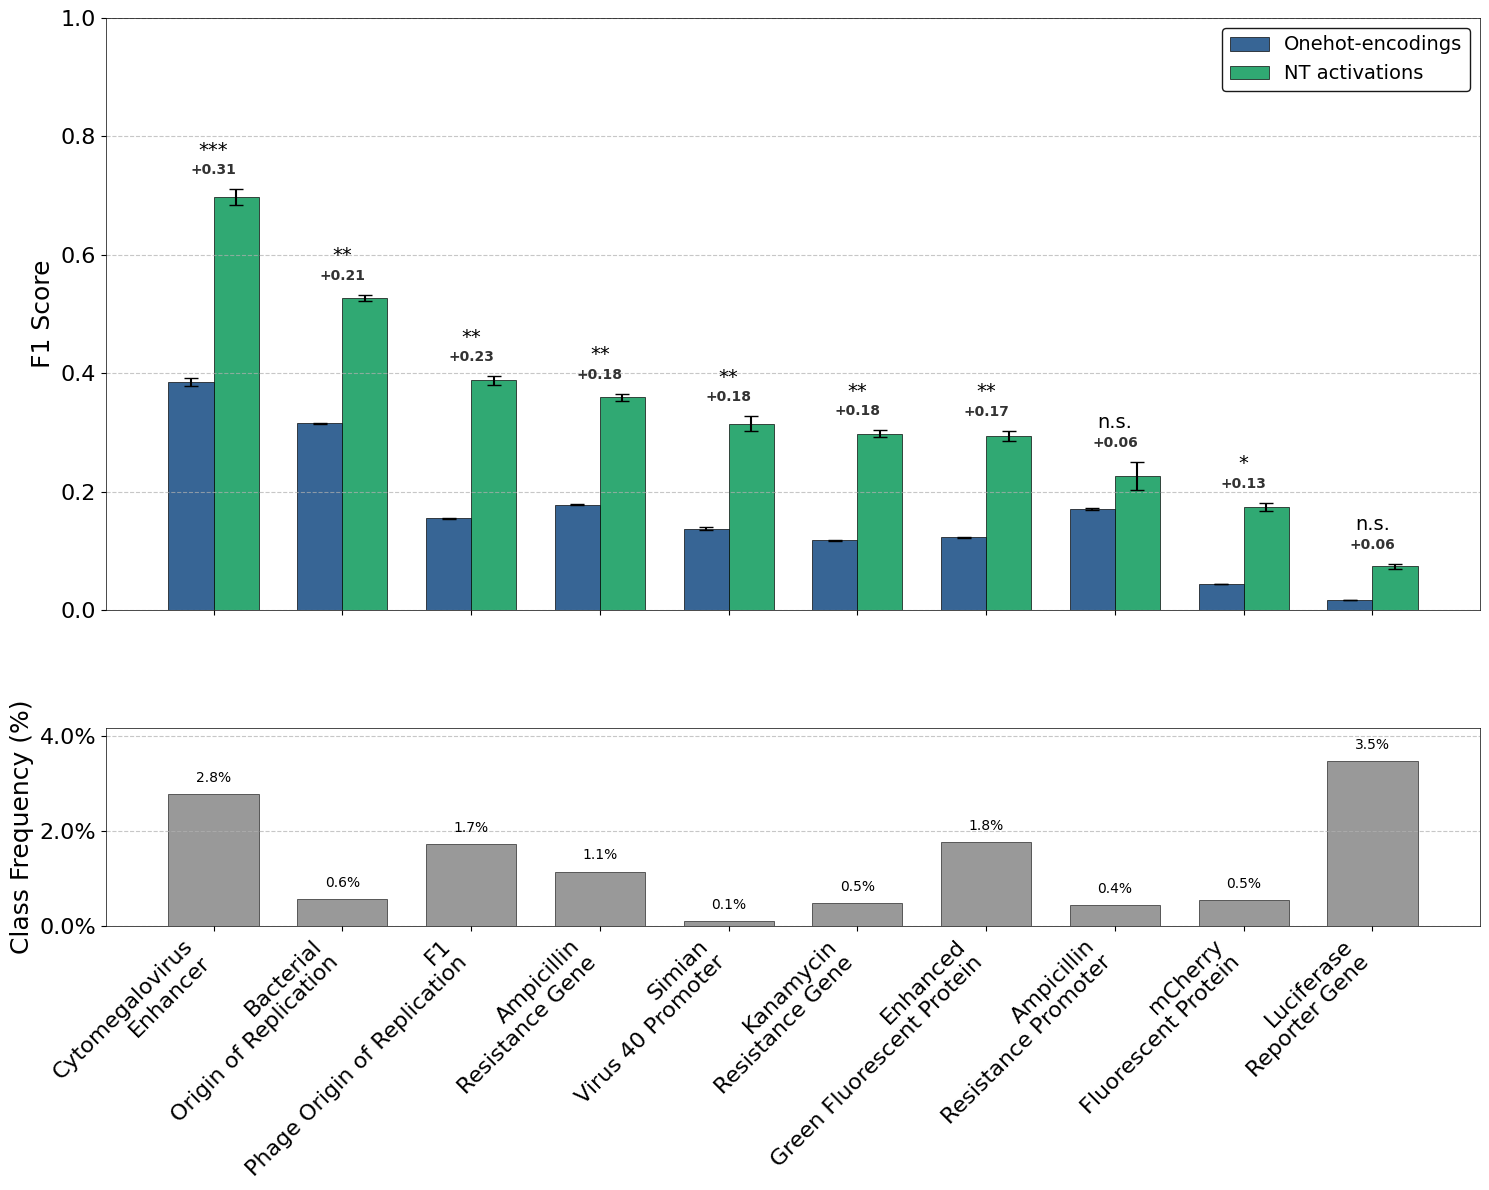

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib.ticker as mtick

# Define fontsize
FS = 18

# List of dataframes and their labels
dfs = [onehot_df, original_df]
labels = ['Onehot-encodings', 'NT activations']
colors = ['#2C5D8F', '#25A56B']  # Darker blue, richer green for better contrast

# Create a dictionary mapping abbreviations to full descriptive names
annotation_full_names = {
    'AmpR': 'Ampicillin Resistance Gene',
    'AmpR promoter': 'Ampicillin Resistance Promoter',
    'CMV enhancer': 'Cytomegalovirus Enhancer',
    'EGFP': 'Enhanced Green Fluorescent Protein',
    'KanR': 'Kanamycin Resistance Gene',
    'SV40 promoter': 'Simian Virus 40 Promoter',
    'f1 ori': 'F1 Phage Origin of Replication',
    'luciferase': 'Luciferase Reporter Gene',
    'mCherry': 'mCherry Fluorescent Protein',
    'ori': 'Bacterial Origin of Replication'
}

# Get the sorted order based on Pretrained NT F1 scores
sorted_indices = original_df['f1'].sort_values(ascending=False).index
annotations = sorted_indices.tolist()

# Create a figure with 2 subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[3, 1], sharex=True)
fig.patch.set_facecolor('white')  # Set white background

# Add thin border around each subplot
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

# Reorder the dataframes according to this sorting
for i, df in enumerate(dfs):
    dfs[i] = df.reindex(annotations)

num_annotations = len(annotations)
bar_width = 0.35
x = np.arange(num_annotations)

# Plot F1 scores on the top subplot
for i, (df, label, color) in enumerate(zip(dfs, labels, colors)):
    positions = x + (i - 0.5) * bar_width
    ax1.bar(
        positions,
        df['f1'],
        yerr=df['f1_std'],
        width=bar_width,
        label=label,
        color=color,
        capsize=5,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.95
    )

# Calculate and show performance improvements
for j, ann in enumerate(annotations):
    improvement = original_df.loc[ann, 'f1'] - onehot_df.loc[ann, 'f1']
    if improvement > 0.05:  # Only show if substantial improvement
        ax1.text(x[j], original_df.loc[ann, 'f1'] + original_df.loc[ann, 'f1_std'] + 0.02,
                 f"+{improvement:.2f}", ha='center', va='bottom', fontsize=FS-8,
                 color='#333333', fontweight='bold')

# Add p-values

p_values = results.set_index('annotation_name')['p_value']

for j, ann in enumerate(annotations):
    p = p_values[ann]
    if p < 0.001:
        ax1.text(x[j], original_df.loc[ann, 'f1'] + original_df.loc[ann, 'f1_std'] + 0.05,
                 "***", ha='center', va='bottom', fontsize=FS-4, color='black')
    elif p < 0.01:
        ax1.text(x[j], original_df.loc[ann, 'f1'] + original_df.loc[ann, 'f1_std'] + 0.05,
                 "**", ha='center', va='bottom', fontsize=FS-4, color='black')
    elif p < 0.05:
        ax1.text(x[j], original_df.loc[ann, 'f1'] + original_df.loc[ann, 'f1_std'] + 0.05,
                 "*", ha='center', va='bottom', fontsize=FS-4, color='black')

    elif p > 0.05:
        ax1.text(x[j], original_df.loc[ann, 'f1'] + original_df.loc[ann, 'f1_std'] + 0.05,
                 "n.s.", ha='center', va='bottom', fontsize=FS-4, color='black')

# Force the y-axis limits explicitly
ax1.set_ylim(0, 1)

# Labeling for top subplot
ax1.set_ylabel('F1 Score', fontsize=FS)
ax1.tick_params(axis='y', labelsize=FS-2)
ax1.legend(fontsize=FS-4, loc='upper right', framealpha=0.9, edgecolor='black', facecolor='white')
ax1.grid(axis='y', linestyle='--', alpha=0.7)


# Plot class frequencies on the bottom subplot with exact values
ax2.bar(x, frequencies*100, width=0.7, color='#808080', alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_ylim(0, max(frequencies*100) * 1.2)  # Add some headroom

# Add numerical labels above each frequency bar
for j, freq in enumerate(frequencies):
    ax2.text(x[j], freq*100 + 0.2, f"{freq*100:.1f}%", ha='center', va='bottom',
             fontsize=FS-8, color='black', rotation=0)

# Formatting for bottom subplot
ax2.set_ylabel('Class Frequency (%)', fontsize=FS)
ax2.tick_params(axis='y', labelsize=FS-2)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Format the y-axis to show percentages with one decimal place
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))

# Use full descriptive names for x-axis labels
full_names = [annotation_full_names.get(ann, ann) for ann in annotations]
wrapped_names = ['\n'.join(name.split(' ', 1)) if ' ' in name else name for name in full_names]

# X-axis labels (only shown on bottom plot due to sharex=True)
ax2.set_xticks(x)
ax2.set_xticklabels(wrapped_names, rotation=45, ha='right', fontsize=FS-2)

# Add a legend for significance levels
significance_elements = [
    Patch(facecolor='none', edgecolor='none', label='Significance:'),
    Patch(facecolor='none', edgecolor='none', label='* p < 0.05'),
    Patch(facecolor='none', edgecolor='none', label='** p < 0.01'),
    Patch(facecolor='none', edgecolor='none', label='*** p < 0.001')
]

# First create the main legend for the data series
legend1 = ax1.legend(fontsize=FS-4, loc='upper right', framealpha=0.9,
                   edgecolor='black', facecolor='white')



# Adjust layout with more space between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Save the figure with high resolution
plt.savefig('linear_probe_performance_with_frequencies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [54]:
p_values

,p_value
annotation_name,
AmpR,0.006249
AmpR promoter,0.175832
CMV enhancer,0.000820
EGFP,0.007599
KanR,0.006374
SV40 promoter,0.006727
f1 ori,0.002504
luciferase,0.172271
mCherry,0.019415


# Results for SAEs trained on pretrained NT

In [ ]:
# load file of pd df results, then plot
import matplotlib.pyplot as plt
import numpy as npResults
import pandas as pd


path = '/content/drive/MyDrive/SAEs_for_Genomics/sae_latent_eval/latent_dictionaries/monosem_meas_latent_dict_nt50m_sae_l12_+40mtokens.csv'
df = pd.read_csv(path)
df.head()

# filter out those with best_f1 below 0.5
df_filtered = df[df['best_f1_val1'] > 0.5]
df_filtered = df_filtered[df_filtered['best_f1_val2'] > 0.5]

df_filtered

# for every annotation that appears multiple times, only keep row with highest f1
df_filtered = df_filtered.sort_values(by=['annotation', 'best_f1_val1'], ascending=[True, False])
df_filtered = df_filtered.drop_duplicates(subset=['annotation'], keep='first')
df_filtered

# Write out the annotations
df_filtered['annotation'] = [
        "5' LTR",
        "C9orf85",
        "CMV Enhancer",
        "CMV Promoter, UL126",
        "Puromycin Resistance",  # expanded from PuroR
        "SV40 Promoter",
        "SV40 Promoter & ORI",  # expanded from SV40 promoter, SV40 ori
        "Streptomycin Resistance",  # expanded from SmR
        "Chicken β-actin Promoter",  # slight cleanup
        "Envelope",  # expanded from env
        "f1 ORI",  # expanded from f1 ori
        "ORI"  # expanded from ori
    ]

In [ ]:

df_filtered['avg_best_f1'] = (df_filtered['best_f1_val1'] + df_filtered['best_f1_val2'])/2

df_filtered['best_f1_thresh_val0'].values

array([11.,  1.,  5.,  5.,  5.,  4.,  5.,  4., 14.,  6.,  4.,  4.])

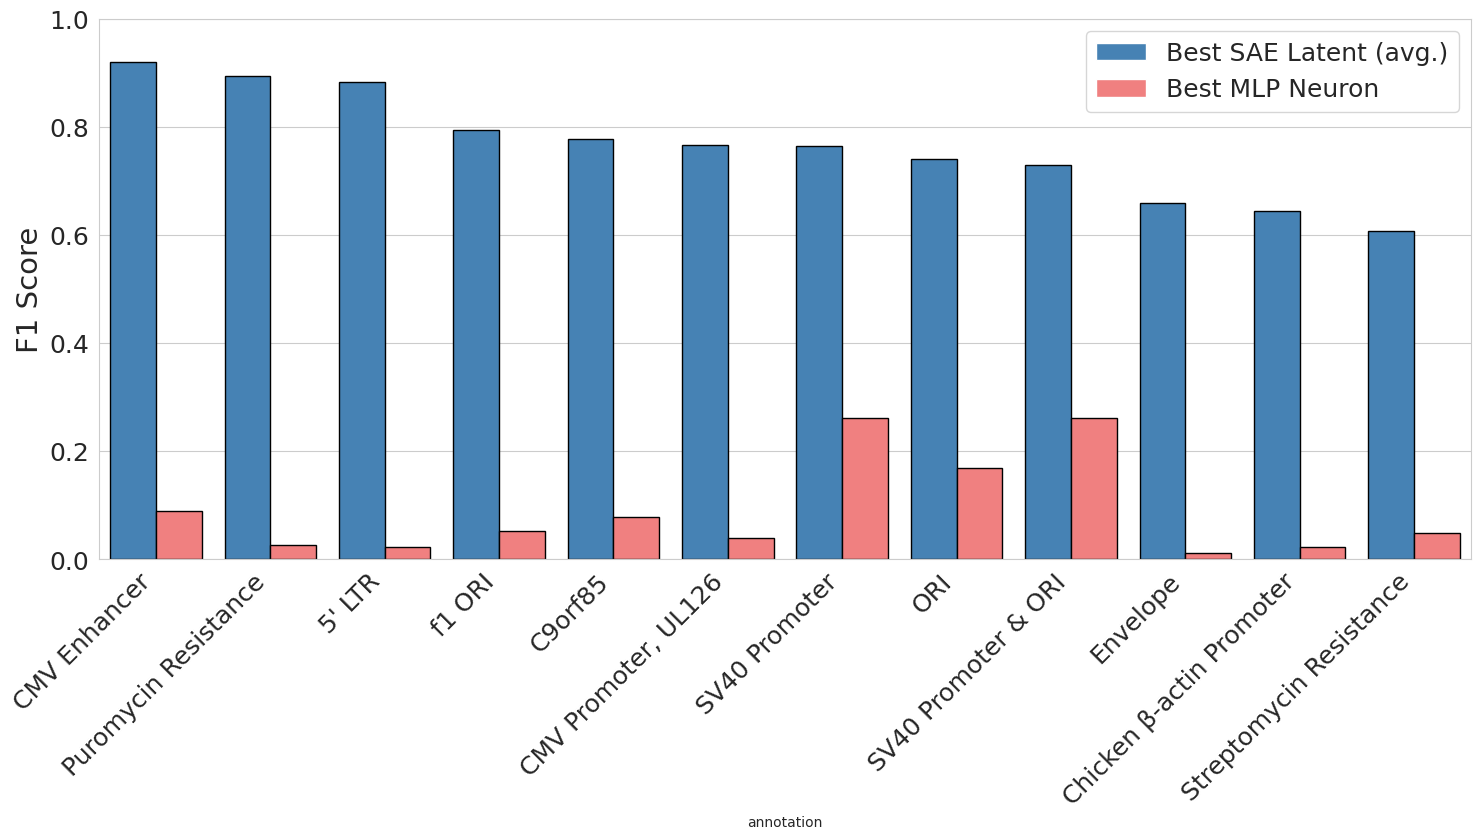

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# CONFIG
FS = config['fontsize']

# Prepare the data
df_filtered['avg_best_f1'] = (df_filtered['best_f1_val1'] + df_filtered['best_f1_val2'])/2

# Reshape the data for seaborn to plot grouped bars
df_melted = pd.melt(
    df_filtered,
    id_vars=['annotation'],
    value_vars=['avg_best_f1', 'best_f1_mlp_neuron'],
    var_name='metric',
    value_name='score'
)

# Sort based on avg_best_f1
sort_order = df_filtered.sort_values('avg_best_f1', ascending=False)['annotation']
df_melted['annotation'] = pd.Categorical(df_melted['annotation'], categories=sort_order, ordered=True)

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8.5))

# Create grouped bar plot
colors = ['steelblue', 'lightcoral']
ax = sns.barplot(
    data=df_melted,
    x='annotation',
    y='score',
    hue='metric',
    palette=colors,
    edgecolor='black',
    capsize=0.1,
    saturation=1

)

# Customize the plot
plt.ylabel('F1 Score', fontsize=FS-3)
plt.xticks(rotation=45, ha='right', fontsize=FS-6)
plt.yticks(fontsize=FS-6)

# Create custom legend handles and labels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Best SAE Latent (avg.)'),
    Patch(facecolor=colors[1], label='Best MLP Neuron')
]
ax.legend(handles=legend_elements, fontsize=FS-6)

# add horizontal dashed line at 0.5

# Set y-axis limits
plt.ylim(0, 1)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_filtered

,latent_id,annotation,best_f1_mlp_neuron,neuron_id_mlp,best_f1_val1,best_f1_val0,best_f1_thresh_val0,best_f1_val2,standard_recall_results_val2,standard_f1_scores_val2,modified_recall_val2,recall_diff_val2,avg_best_f1
0,52,5' LTR,0.022222,371.0,0.837209,0.434783,11.0,0.927273,0.066062,0.122744,1.000000,0.933938,0.882241
93,1884,C9orf85,0.076923,370.0,0.740920,0.965517,1.0,0.811594,0.101449,0.180645,0.800000,0.698551,0.776257
156,3130,CMV Enhancer,0.088244,422.0,0.920716,0.916662,5.0,0.916664,0.050294,0.095706,0.856410,0.806117,0.918690
108,2297,"CMV Promoter, UL126",0.038296,180.0,0.773866,0.728379,5.0,0.758591,0.033520,0.064079,0.798817,0.765297,0.766228
44,946,Puromycin Resistance,0.025675,280.0,0.875973,0.847603,5.0,0.912680,0.450137,0.600733,0.923077,0.472940,0.894326
171,3450,SV40 Promoter,0.261084,163.0,0.776471,0.647120,4.0,0.750993,0.038091,0.073353,0.605769,0.567678,0.763732
91,1818,SV40 Promoter & ORI,0.261084,163.0,0.721269,0.787881,5.0,0.736343,0.177243,0.280439,0.815385,0.638142,0.728806
3,81,Streptomycin Resistance,0.048705,358.0,0.527417,0.641859,4.0,0.687590,0.354819,0.464328,0.703704,0.348884,0.607503
57,1239,Chicken β-actin Promoter,0.022222,79.0,0.597826,0.655089,14.0,0.691244,0.033025,0.063613,0.576923,0.543898,0.644535
60,1264,Envelope,0.011957,358.0,0.665484,0.579830,6.0,0.651463,0.262881,0.350730,0.852941,0.590060,0.658473


## How much does Domain-Recall differ from Standard Recall?

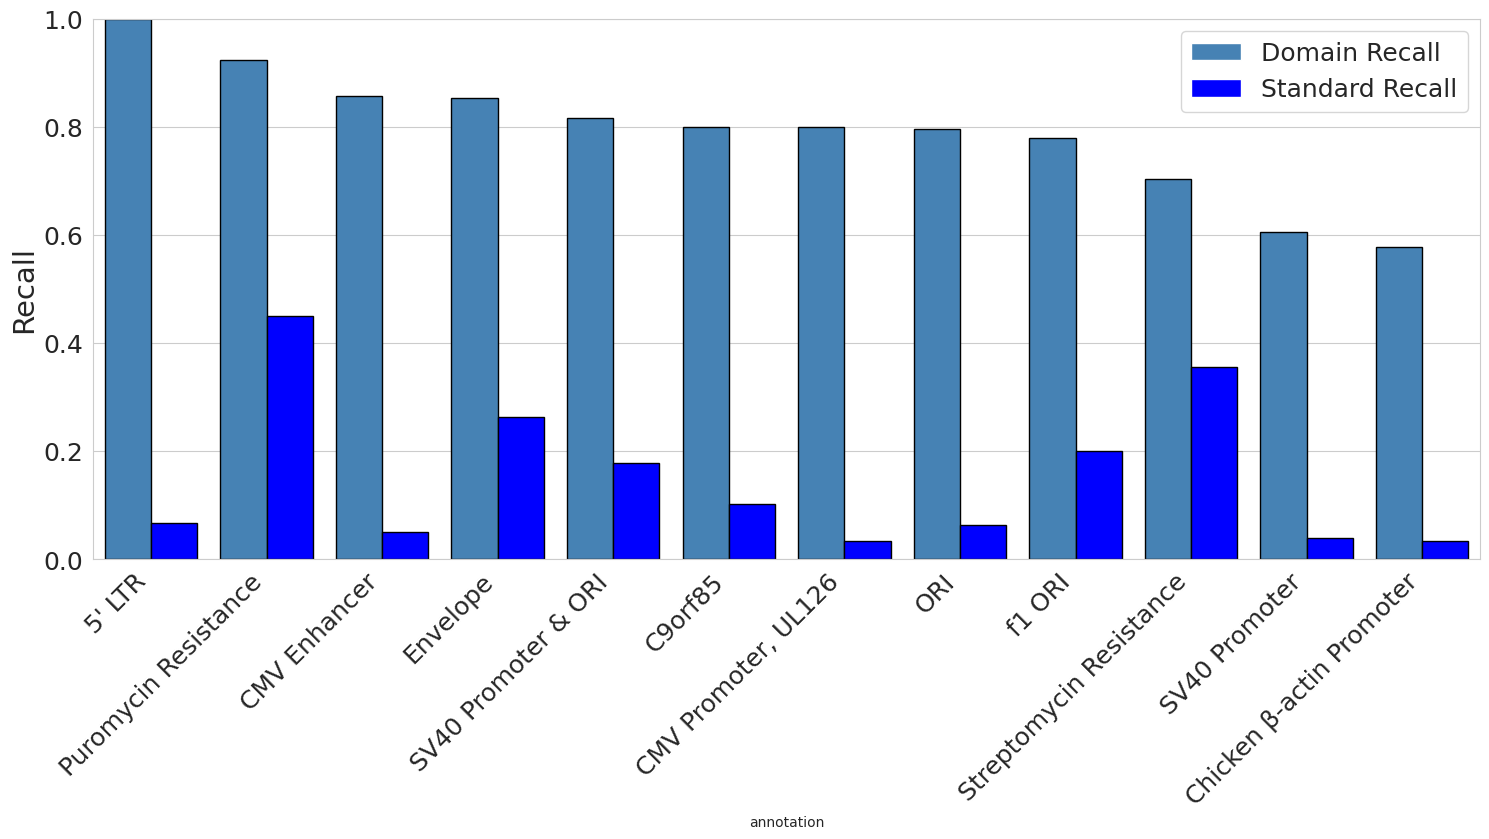

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# CONFIG
FS = config['fontsize']

# Reshape the data for seaborn to plot grouped bars
df_melted = pd.melt(
    df_filtered,
    id_vars=['annotation'],
    value_vars=['modified_recall_val2', 'standard_recall_results_val2'],
    var_name='metric',
    value_name='score'
)

# Sort based on modified_recall_val2
sort_order = df_filtered.sort_values('modified_recall_val2', ascending=False)['annotation']
df_melted['annotation'] = pd.Categorical(df_melted['annotation'], categories=sort_order, ordered=True)

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8.5))

# Create grouped bar plot
colors = ['steelblue', 'blue']
ax = sns.barplot(
    data=df_melted,
    x='annotation',
    y='score',
    hue='metric',
    palette=colors,
    edgecolor='black',
    capsize=0.1,
    saturation=1

)

# Customize the plot
plt.ylabel('Recall', fontsize=FS-3)
plt.xticks(rotation=45, ha='right', fontsize=FS-6)
plt.yticks(fontsize=FS-6)

# Create custom legend handles and labels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Domain Recall'),
    Patch(facecolor=colors[1], label='Standard Recall')
]
ax.legend(handles=legend_elements, fontsize=FS-6)

# add horizontal dashed line at 0.5

# Set y-axis limits
plt.ylim(0, 1)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

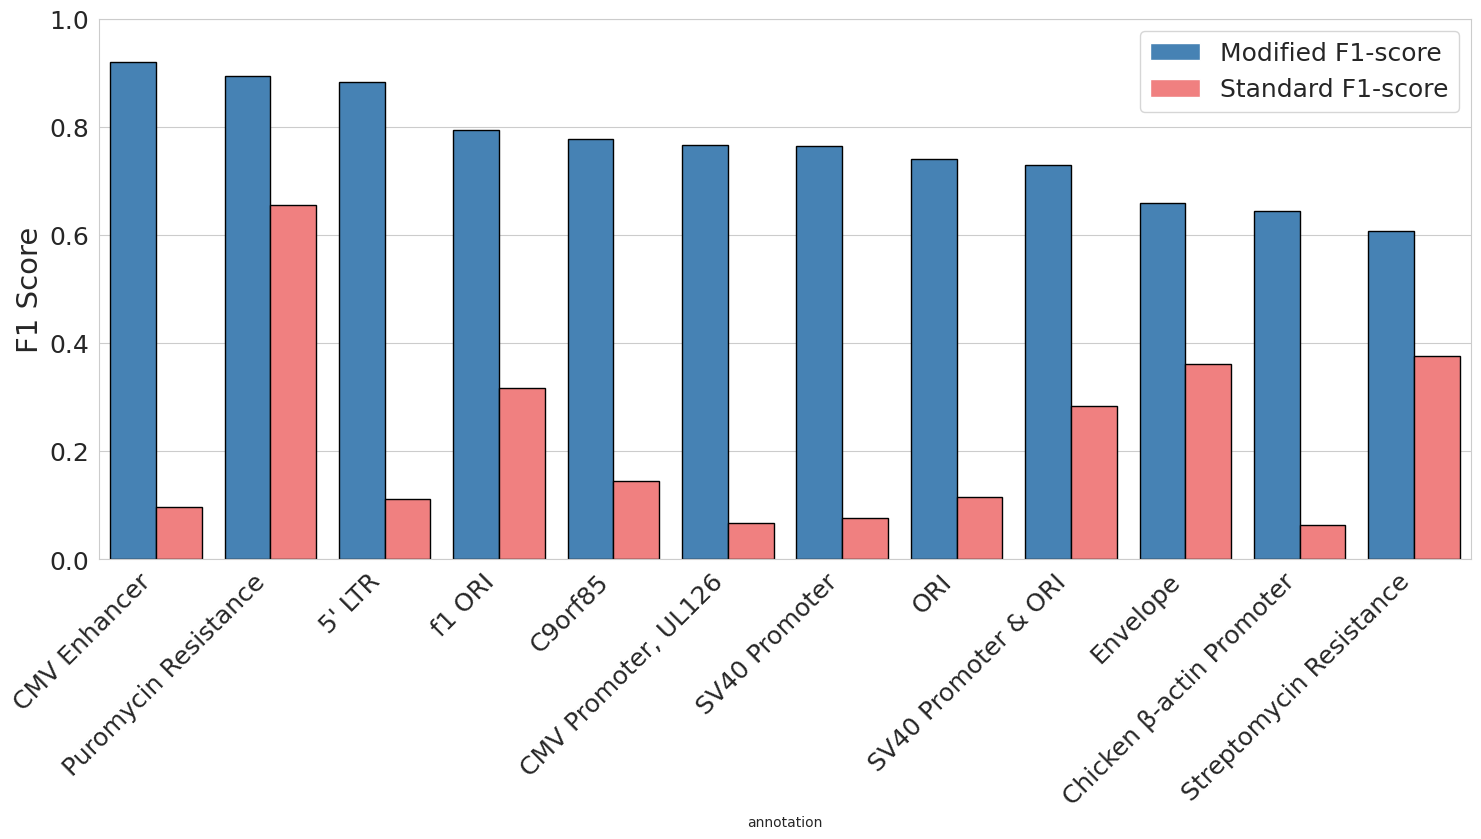

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# CONFIG
FS = config['fontsize']

# Prepare the data
df_filtered['avg_best_f1'] = (df_filtered['best_f1_val1'] + df_filtered['best_f1_val2'])/2
df_filtered['avg_best_f1_standard'] = (df_filtered['standard_f1_scores_val2'] + df_filtered['standard_f1_scores_val1'])/2

# Reshape the data for seaborn to plot grouped bars
df_melted = pd.melt(
    df_filtered,
    id_vars=['annotation'],
    value_vars=['avg_best_f1', 'avg_best_f1_standard'], ## only standard for val2!
    var_name='metric',
    value_name='score'
)

# Sort based on avg_best_f1
sort_order = df_filtered.sort_values('avg_best_f1', ascending=False)['annotation']
df_melted['annotation'] = pd.Categorical(df_melted['annotation'], categories=sort_order, ordered=True)

# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8.5))

# Create grouped bar plot
colors = ['steelblue', 'lightcoral']
ax = sns.barplot(
    data=df_melted,
    x='annotation',
    y='score',
    hue='metric',
    palette=colors,
    edgecolor='black',
    capsize=0.1,
    saturation=1

)

# Customize the plot
plt.ylabel('F1 Score', fontsize=FS-3)
plt.xticks(rotation=45, ha='right', fontsize=FS-6)
plt.yticks(fontsize=FS-6)

# Create custom legend handles and labels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Modified F1-score'),
    Patch(facecolor=colors[1], label='Standard F1-score')
]
ax.legend(handles=legend_elements, fontsize=FS-6)

# add horizontal dashed line at 0.5

# Set y-axis limits
plt.ylim(0, 1)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Results for SAE on random init NT

In [ ]:
# load file of pd df results, then plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


path = '/content/drive/MyDrive/SAEs_for_Genomics/latent_dict_nt50m.RANDOM_sae.best_l11_48mtokens.csv'
df_random = pd.read_csv(path)


# for every annotation that appears multiple times, only keep row with highest f1
df_random_filtered = df_random.sort_values(by=['annotation', 'best_f1_val1'], ascending=[True, False])
df_random_filtered = df_random_filtered.drop_duplicates(subset=['annotation'], keep='first')
df_random_filtered

print(df_random_filtered)

df_random_filtered['avg_val_f1'] = (df_random_filtered['best_f1_val1'] + df_random_filtered['best_f1_val2'])/2
df_random_filtered

    latent_id                           annotation  best_f1_val0  \
81      12602                               'AmpR'      0.095012   
15       1734  'CMV IE94 promoter', 'CMV enhancer'      0.000000   
8         734                       'CMV enhancer'      0.450579   
35       4976       'CMV promoter', 'CMV enhancer'      0.005988   
97      15769                             'COL4A5'      0.172925   
41       6037                               'EGFP'      0.438441   
99      16136                                'Myc'      0.563380   
55       8323                      'SV40 promoter'      0.372794   
70      10685                              'UL126'      0.194131   
53       8011              'UL126', 'CMV promoter'      0.000000   
17       2185                             'mVenus'      0.273684   
20       2617                 'tight TRE promoter'      0.341880   

    best_f1_thresh_val0  best_f1_val1  best_f1_val2  
81                  0.0      0.077586      0.080508  
15     

,latent_id,annotation,best_f1_val0,best_f1_thresh_val0,best_f1_val1,best_f1_val2,avg_val_f1
81,12602,'AmpR',0.095012,0.0,0.077586,0.080508,0.079047
15,1734,"'CMV IE94 promoter', 'CMV enhancer'",0.000000,0.0,0.010283,0.000000,0.005141
8,734,'CMV enhancer',0.450579,1.0,0.383441,0.330830,0.357135
35,4976,"'CMV promoter', 'CMV enhancer'",0.005988,0.0,0.003125,0.000000,0.001563
97,15769,'COL4A5',0.172925,1.0,0.009668,0.000000,0.004834
41,6037,'EGFP',0.438441,3.0,0.312931,0.333516,0.323224
99,16136,'Myc',0.563380,7.0,0.190476,0.000000,0.095238
55,8323,'SV40 promoter',0.372794,5.0,0.353247,0.445078,0.399163
70,10685,'UL126',0.194131,1.0,0.140969,0.225000,0.182985
53,8011,"'UL126', 'CMV promoter'",0.000000,0.0,0.000000,0.000000,0.000000


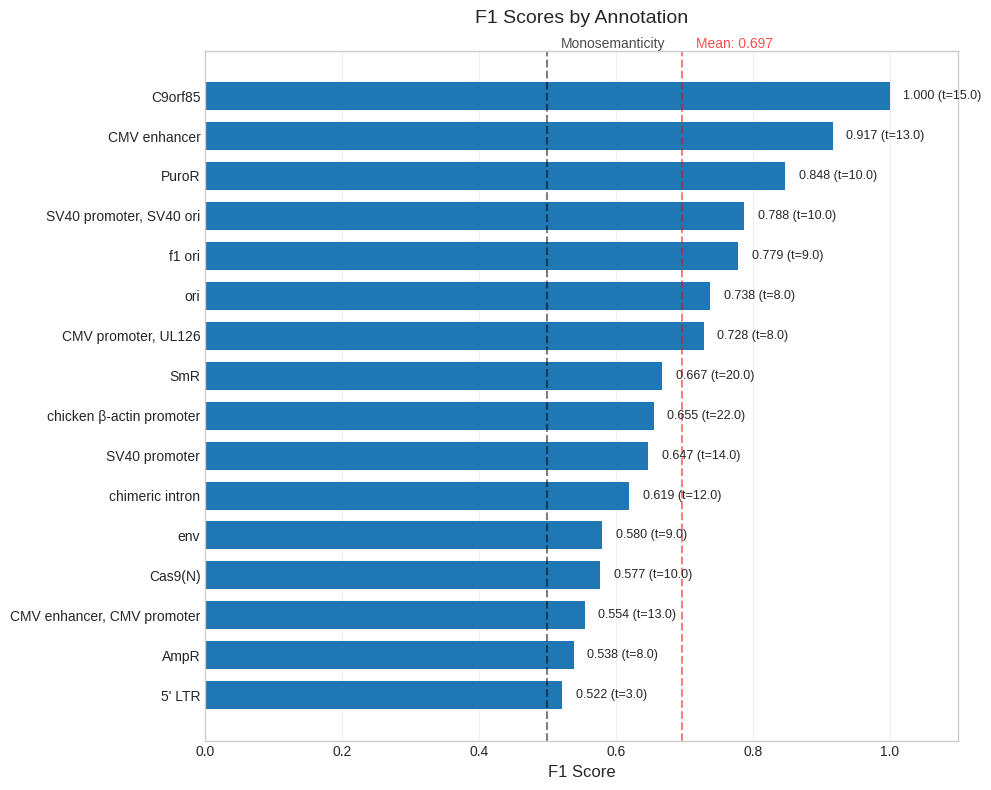


Summary Statistics:
Number of annotations: 16
Mean F1 score: 0.697
Median F1 score: 0.661
Max F1 score: 1.000
Min F1 score: 0.522


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the data


# Convert to DataFrame and sort by F1 score
df = pd.DataFrame(data)
df = df.sort_values('f1', ascending=True)  # Ascending for bottom-to-top display

# Calculate mean F1 score
mean_f1 = df['f1'].mean()

# Set up the plot style
plt.style.use('seaborn-v0_8-whitegrid')


# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create horizontal bars
bars = ax.barh(range(len(df)), df['f1'], height=0.7)

# Customize the plot
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['annotation'], fontsize=10)
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_xlim(0, 1.1)  # Add some space for labels

# Add value labels and thresholds
for i, bar in enumerate(bars):
    width = bar.get_width()
    f1_value = df['f1'].iloc[i]
    threshold = df['threshold'].iloc[i]
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f'{f1_value:.3f} (t={threshold})',
            va='center', fontsize=9)

# Add mean line
ax.axvline(mean_f1, color='red', linestyle='--', alpha=0.5)
ax.text(mean_f1 + 0.02, ax.get_ylim()[1], f'Mean: {mean_f1:.3f}',
        va='bottom', ha='left', color='red', alpha=0.7)

# Add line at 0.5 to visualise cut-off
ax.axvline(.5, color='black', linestyle='--', alpha=0.5)
ax.text(0.5 + 0.02, ax.get_ylim()[1], 'Monosemanticity',
        va='bottom', ha='left', color='black', alpha=0.7)

# Customize grid
ax.grid(True, axis='x', alpha=0.3)
ax.grid(False, axis='y')

# Add title and adjust layout
plt.title('F1 Scores by Annotation', pad=20, fontsize=14)
plt.tight_layout()

# Optional: Save the figure
# plt.savefig('f1_scores.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('f1_scores.png', bbox_inches='tight', dpi=300)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Number of annotations: {len(df)}")
print(f"Mean F1 score: {df['f1'].mean():.3f}")
print(f"Median F1 score: {df['f1'].median():.3f}")
print(f"Max F1 score: {df['f1'].max():.3f}")
print(f"Min F1 score: {df['f1'].min():.3f}")

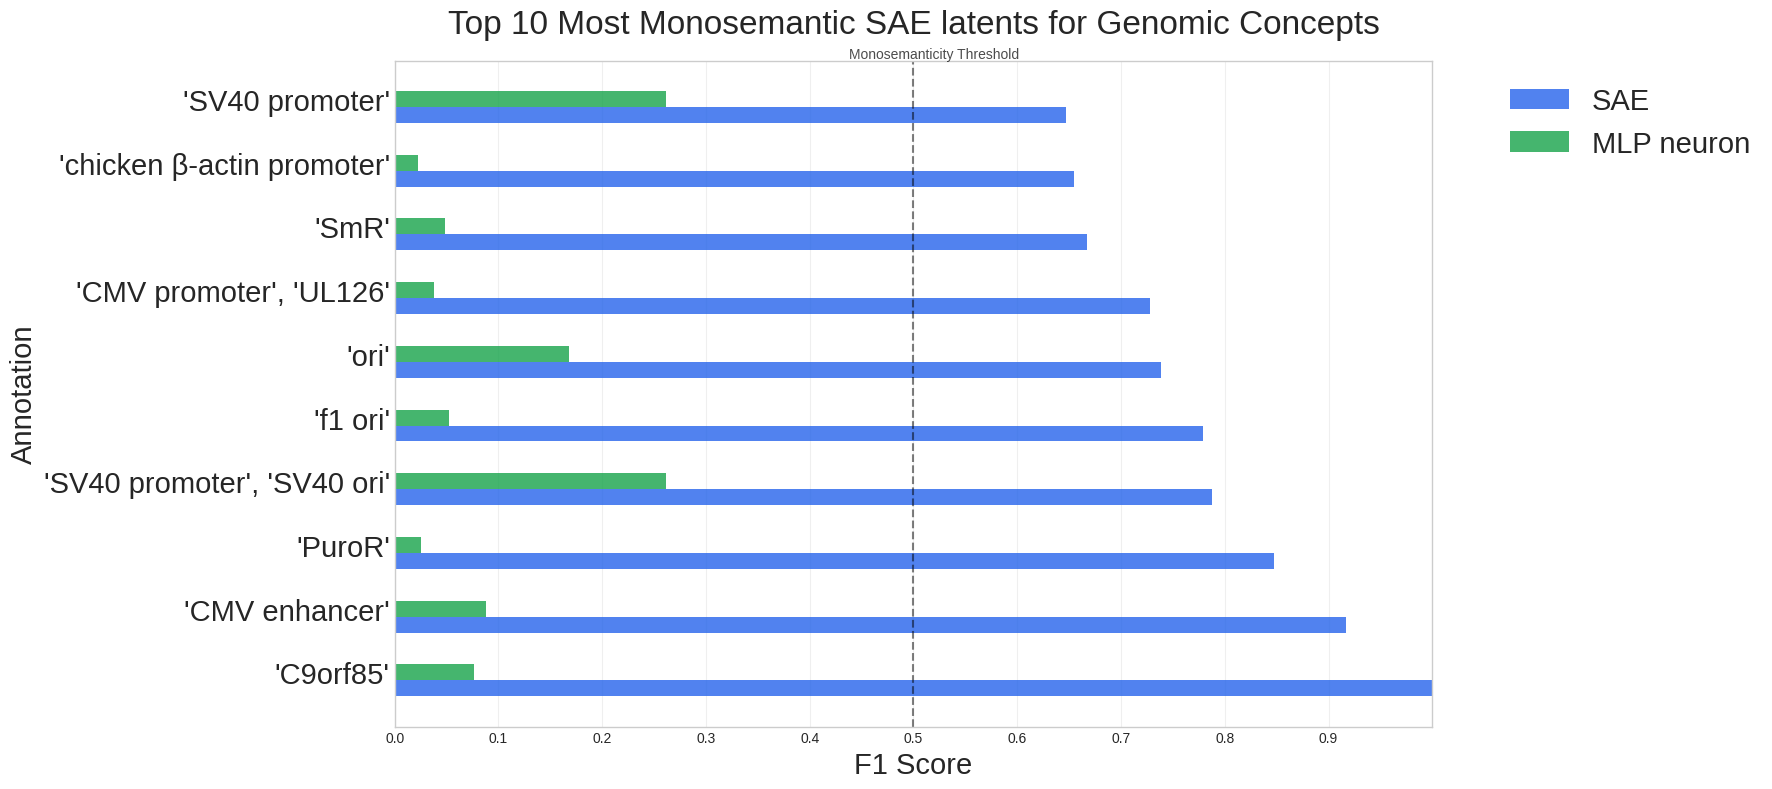

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Convert to DataFrame
df = df_filtered

# fontsize
FS = 24

# Sort by SAE score and get top 10
df = df.sort_values('best_f1', ascending=False).head(10)

# Create synthetic data for MLP neuron and Random gLM (for demonstration)
# You should replace these with your actual metrics
df['MLP neuron'] = df['best_f1_mlp_neuron']
#df['Random gLM'] = df['SAE'] * np.random.uniform(0.7, 1, len(df))

# Set up the plot style
plt.style.use('seaborn-v0_8-whitegrid')


# Create the figure and axis
fig, ax = plt.subplots(figsize=(18, 8))

# Define bar colors and width
bar_width = 0.25
colors = ['#2563eb', '#16a34a', '#dc2626']  # blue, green, red
opacity = 0.8

# Create bars for each metric
y_pos = np.arange(len(df))
bars1 = ax.barh(y_pos - bar_width, df['best_f1'], bar_width,
                alpha=opacity, color=colors[0], label='SAE')
bars2 = ax.barh(y_pos, df['MLP neuron'], bar_width,
                alpha=opacity, color=colors[1], label='MLP neuron')
#bars3 = ax.barh(y_pos + bar_width, df['Random gLM'], bar_width,
#                alpha=opacity, color=colors[2], label='Random gLM')

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(df['annotation'], fontsize=FS-3)
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.0, 0.1))
ax.set_ylabel('Annotation', fontsize=FS-3)
ax.set_xlabel('F1 Score', fontsize=FS-3)

# add vertical line at 0.5 to mark monosemanticity threshold with text
ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
ax.text(0.5 + 0.02, ax.get_ylim()[1], 'Monosemanticity Threshold',
        va='bottom', ha='center', color='black', alpha=0.7)

# Add value labels
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}',
                va='center', fontsize=FS-6)

#add_labels(bars1, df['SAE'])
#add_labels(bars2, df['MLP neuron'])
#add_labels(bars3, df['Random gLM'])

# Customize grid
ax.grid(True, axis='x', alpha=0.3)
ax.grid(False, axis='y')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FS-3)

# Add title and adjust layout
plt.title('Top 10 Most Monosemantic SAE latents for Genomic Concepts', pad=20, fontsize=FS)
plt.tight_layout()

# Optional: Save the figure
# plt.savefig('top10_scores.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('top10_scores.png', bbox_inches='tight', dpi=300)

plt.show()
